In [1]:
import sys ; sys.path.insert(0, "..")
import time
from collections import namedtuple
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch_geometric.loader import DataLoader

from src.datasets.dbg import dBGDataset
from src.models.gcn import GCN

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
KMER = 7
EPOCHS = 300
outdir = Path(f"../experiments/dbg/{KMER}mer")
outdir.mkdir(exist_ok=True, parents=True)

In [4]:
dbg_dataset = dBGDataset(root=Path(f"../data/dbg/{KMER}mer"), k=KMER, 
                         files=[
                             "../data/subsample-clade_G.fasta",
                             "../data/subsample-random.fasta",
                             "../data/subsample-clade_O.fasta",
                             "../data/subsample-clade_S.fasta",
                            ], 
                        format="fasta")

In [5]:
dbg_dataset.len()

20000

In [6]:
# dbg_dataset.num_classes

In [7]:
model = GCN(hidden_channels=64, num_node_features=dbg_dataset.num_node_features, num_classes=4)
model.to(device)
print(model)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)


In [8]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

nsplit = int(0.8*dbg_dataset.len())
dbg_dataset.shuffle()
train_loader = DataLoader(dbg_dataset[:nsplit], batch_size = 32 , shuffle = True, num_workers=4)
val_loader = DataLoader(dbg_dataset[nsplit:], batch_size = 32 , shuffle = False, num_workers=4)

In [9]:
# for epoch in range(2):
#     lloss = []
#     for data in train_loader:
#         data = data.to(device)
#         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
#         # out = F.softmax(out, dim=-1)
#         loss = criterion(out, data.y)  # Compute the loss.
#         loss.backward()  # Derive gradients.
#         # for name, param in model.named_parameters():
#         #     print(name, param.grad)
#         optimizer.step()  # Update parameters based on gradients.
#         optimizer.zero_grad()  # Clear gradients.
        
#         lloss.append(loss.cpu().detach().numpy())

#     m_loss = np.array(lloss).mean()

#     lloss.append(loss.cpu().detach().numpy())
#     print(f'Epoch: {epoch:03d}, Loss: {m_loss:.4f}') 


In [10]:
Epoch = namedtuple("Epoch",["train_loss","val_loss","train_acc", "val_acc", "saved_model", "time"])
info_epochs = []
best_loss = 1_000_000

for epoch in range(EPOCHS):

    t0 = time.time()

    model.train()
    train_loss = []
    train_preds = []
    train_labels = []

    for data in train_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        train_loss.append(loss.cpu().detach().numpy())

        preds = out.argmax(axis=-1).cpu().detach().numpy()
        train_preds.extend(preds)
        train_labels.extend(data.y.cpu().detach().numpy())
        train_loss.append(loss.cpu().detach().numpy())

    # validation 
    model.eval()
    val_loss = []
    val_preds = []
    val_labels = []
    
    with torch.no_grad():
        for data in val_loader:
            data = data.to(device)
            out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
            loss = criterion(out, data.y)  # Compute the loss.
            preds = out.argmax(axis=-1).cpu().detach().numpy()
            val_preds.extend(preds)
            val_labels.extend(data.y.cpu().detach().numpy())
            val_loss.append(loss.cpu().detach().numpy())

    # epoch metrics
    m_train_loss = np.array(train_loss).mean()
    m_val_loss = np.array(val_loss).mean()
    acc_train = (np.array(train_preds) == np.array(train_labels)).sum() / len(train_labels)
    acc_val = (np.array(val_preds) == np.array(val_labels)).sum() / len(val_labels)

    # save best model
    saved_model = False
    if m_val_loss < best_loss:
        print(m_val_loss, best_loss)
        torch.save(model.state_dict(), outdir.joinpath("best_model.pt"))
        best_loss = m_val_loss
        saved_model = True

    delta_t = time.time() - t0
    info_epochs.append( Epoch(m_train_loss, m_val_loss, acc_train, acc_val, saved_model, delta_t) )
    print(f'Epoch: {epoch:03d}, Train-Loss: {m_train_loss:.4f}  | Val-Loss: {m_val_loss:.4f} | Best-Loss: {best_loss} | Train-Acc: {acc_train} | Val-Acc: {acc_val}') 


0.8374288 1000000
Epoch: 000, Train-Loss: 1.0483  | Val-Loss: 0.8374 | Best-Loss: 0.8374288082122803 | Train-Acc: 0.468625 | Val-Acc: 0.86225
0.19135381 0.8374288
Epoch: 001, Train-Loss: 0.9658  | Val-Loss: 0.1914 | Best-Loss: 0.19135381281375885 | Train-Acc: 0.5111875 | Val-Acc: 0.999
0.17160177 0.19135381
Epoch: 002, Train-Loss: 0.9275  | Val-Loss: 0.1716 | Best-Loss: 0.1716017723083496 | Train-Acc: 0.521125 | Val-Acc: 0.99125
0.052807707 0.17160177
Epoch: 003, Train-Loss: 0.8882  | Val-Loss: 0.0528 | Best-Loss: 0.05280770733952522 | Train-Acc: 0.5504375 | Val-Acc: 0.99125
Epoch: 004, Train-Loss: 0.8804  | Val-Loss: 1.1206 | Best-Loss: 0.05280770733952522 | Train-Acc: 0.549625 | Val-Acc: 0.29875
0.033408012 0.052807707
Epoch: 005, Train-Loss: 0.8712  | Val-Loss: 0.0334 | Best-Loss: 0.03340801224112511 | Train-Acc: 0.5508125 | Val-Acc: 0.99125
0.0059654177 0.033408012
Epoch: 006, Train-Loss: 0.8689  | Val-Loss: 0.0060 | Best-Loss: 0.005965417716652155 | Train-Acc: 0.552125 | Val-Acc: 

In [11]:
train_metrics = pd.DataFrame(info_epochs)
train_metrics.to_csv(outdir.joinpath(f"train_metrics-{KMER}mer.csv"))

### Plots

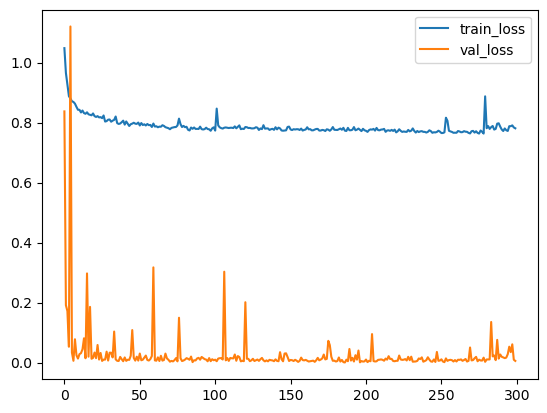

In [12]:
train_metrics[["train_loss","val_loss"]].plot()
plt.savefig(outdir.joinpath("training-loss.jpg"))

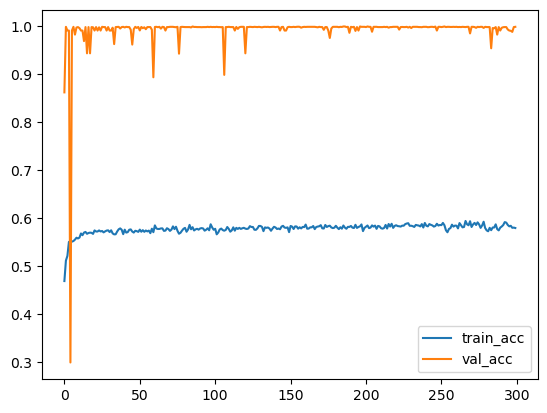

In [13]:
train_metrics[["train_acc","val_acc"]].plot()
plt.savefig(outdir.joinpath("training-acc.jpg"))

___
### Test

In [14]:
list_fcgr = list(Path(f"../data/fcgr-test/{KMER}mer").rglob("*npy"))

test_dataset = dBGDataset(root=Path(f"../data/dbg-test/{KMER}mer"), k=KMER, 
                         files=[
                             "../data/test-clade_G.fasta",
                             "../data/test-random.fasta",
                             "../data/test-clade_O.fasta",
                             "../data/test-clade_S.fasta",
                            ], 
                        format="fasta")
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
model = GCN(hidden_channels=64, num_node_features=test_dataset.num_node_features, num_classes=4)
model.load_state_dict(torch.load( outdir.joinpath("best_model.pt")))
model.to(device)

GCN(
  (conv1): GCNConv(1, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=4, bias=True)
)

In [16]:
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        preds = out.argmax(axis=-1).cpu().detach().numpy()
        test_preds.extend(preds)
        test_labels.extend(data.y.cpu().detach().numpy())
        

acc_test = (np.array(train_preds) == np.array(train_labels)).sum() / len(train_labels)
print(acc_test)

0.5793125


In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
cm = confusion_matrix(test_labels, test_preds,)
labels = [l.split("-")[-1] for l in test_dataset.filename2label.keys()]
disp = ConfusionMatrixDisplay(cm, display_labels=labels,)

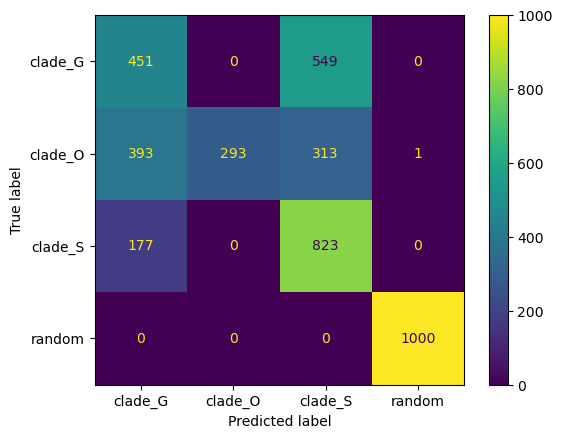

In [18]:
disp.plot()
plt.savefig(outdir.joinpath("confusion-matrix.jpg"))